In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

from wrf_hr_utils import *
from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat,humidsat
from orographicConvectionTheory.orographicConvectionTheory import *
from orographicPrecipitation.observationsAndERA5.linearWaveModels import linear_w_1layer,w_to_Tprime,linear_w_generalized
from orographicPrecipitation.observationsAndERA5.mountainUtils import compute_N

SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [2]:
xr.set_options(display_style='text') 

In [3]:
from dask.distributed import Client
client=Client()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37141 instead
  http_address["port"], self.http_server.port


In [6]:
drydeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/wrfinput_d01')
drydeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/')

dry10kmdeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.10km/wrfinput_d01')
dry10kmdeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.10km/')

dry20kmdeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.20km/wrfinput_d01')
dry20kmdeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.20km/')

dry50kmdeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.50km/wrfinput_d01')
dry50kmdeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.50km/')


In [4]:
nocp20kmdeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.20km/wrfinput_d01')
nocp20kmdeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.20km/')

zmf20kmdeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.zmf.20km/wrfinput_d01')
zmf20kmdeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.zmf.20km/')

tiedtke20kmdeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.tiedtke.20km/wrfinput_d01')
tiedtke20kmdeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.tiedtke.20km/')

nocp50kmdeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.50km/wrfinput_d01')
nocp50kmdeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.50km/')


In [7]:
class Simulation():
    def __init__(self,data,siminput,center,dx):
        self.data = data
        self.input = siminput
        self.center = center
        self.dx = dx
dx3 = Simulation(drydeepchannel,drydeepinput,1635,3)
dx10 = Simulation(dry10kmdeepchannel,dry10kmdeepinput,487,10)
dx20 = Simulation(dry20kmdeepchannel,dry20kmdeepinput,250,20)
dx50 = Simulation(dry50kmdeepchannel,dry50kmdeepinput,100,50)

nocpdx20    = Simulation(nocp20kmdeepchannel,nocp20kmdeepinput,250,20)
zmfdx20     = Simulation(zmf20kmdeepchannel,zmf20kmdeepinput,250,20)
tiedtkedx20 = Simulation(tiedtke20kmdeepchannel,tiedtke20kmdeepinput,250,20)
nocpdx50    = Simulation(nocp50kmdeepchannel,nocp50kmdeepinput,100,50)

In [8]:
def hatprime(var,idx1,idx2):
    """Vertically average variable between two pressure levels indicated by their indices (idx1 and idx2), and take deviation from upstream value"""
    varhat = var[idx1:idx2].integrate('pressure')/(var.pressure[idx2]-var.pressure[idx1])
    return varhat - varhat.sel(distance_from_mtn=slice(-3000,-4500)).mean('distance_from_mtn')

In [9]:
hrhgt = change_coords_sfc(drydeepinput.HGT[0,0])

# Dry runs

## W

In [29]:
%%time
for sim in (dx3,dx10,dx20,dx50):
    w_temp = sim.data.W[120:160].mean(['Time','south_north']).load()
    sim.wmean = interp_eta_to_pressure(sim.data,change_coords_eta(sim.data,w_temp,staggered=True,center=sim.center,dx=sim.dx),1,dsinput=sim.input)

CPU times: user 1.43 s, sys: 254 ms, total: 1.69 s
Wall time: 18.7 s


In [39]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n
wlevs=levs(0.4,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

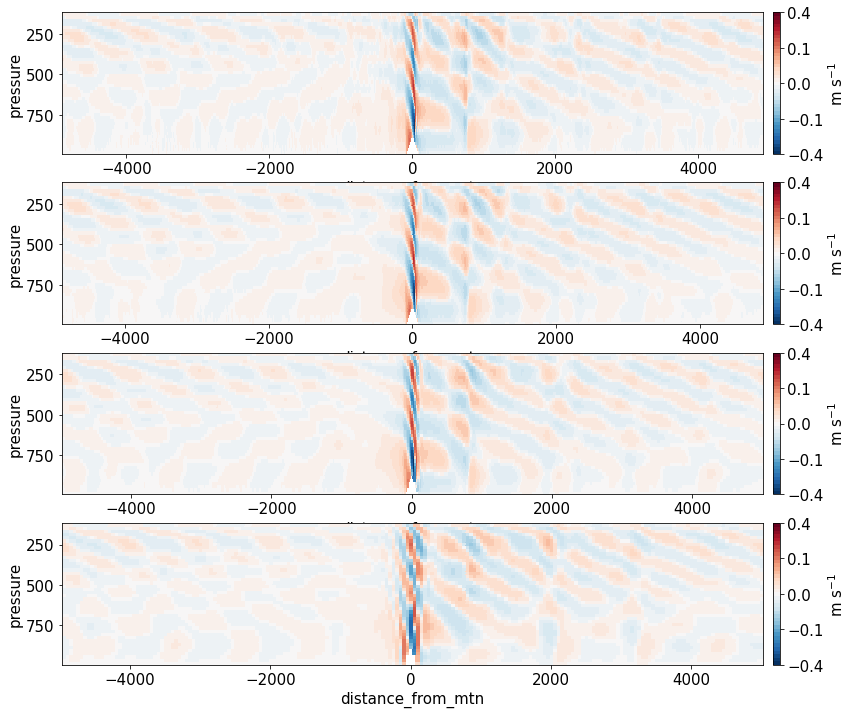

In [40]:
fig,axs = plt.subplots(4,1,figsize=(15,12))
for ax,sim in zip(axs,(dx3,dx10,dx20,dx50)):
    sim.wmean.plot(ax=ax,y='pressure',yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})

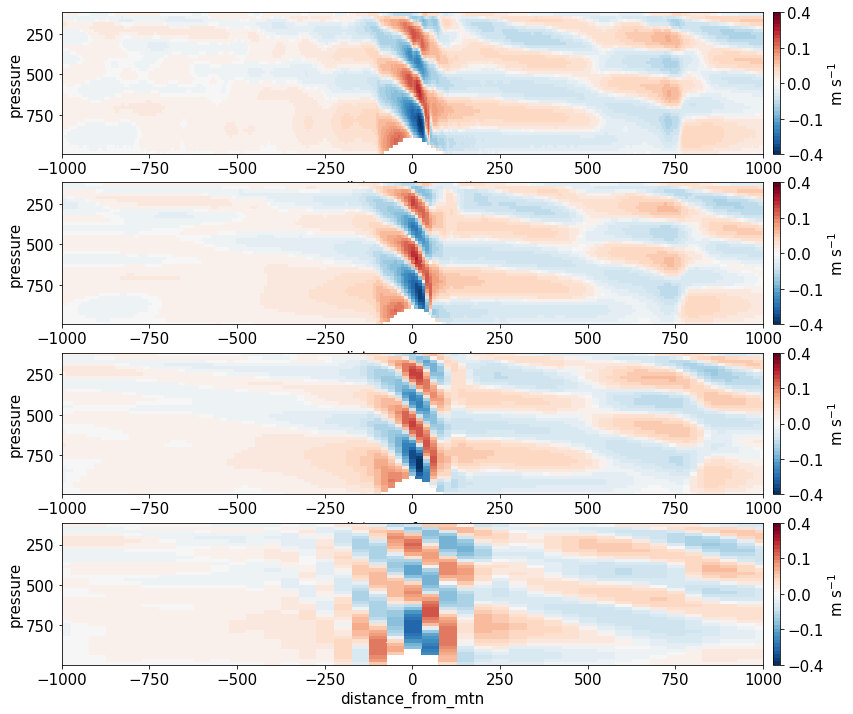

In [41]:
fig,axs = plt.subplots(4,1,figsize=(15,12))
for ax,sim in zip(axs,(dx3,dx10,dx20,dx50)):
    sim.wmean.plot(ax=ax,y='pressure',yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})
    ax.set_xlim(-1000,1000)

(-100.0, 4000.0)

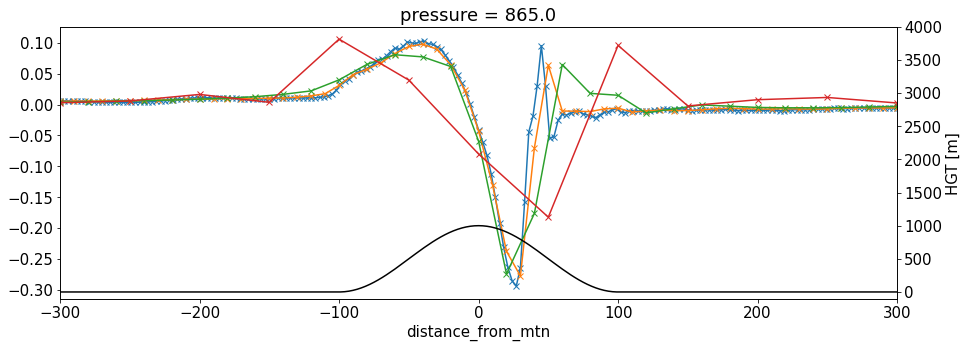

In [42]:
plt.figure(figsize=(15,5))
dx3 .wmean[6].plot(marker='x')
dx10.wmean[6].plot(marker='x')
dx20.wmean[6].plot(marker='x')
dx50.wmean[6].plot(marker='x')
plt.twinx()
hrhgt.plot(color='k')
plt.xlim(-300,300)
plt.ylim(-100,4000)

(1000.0, 100.0)

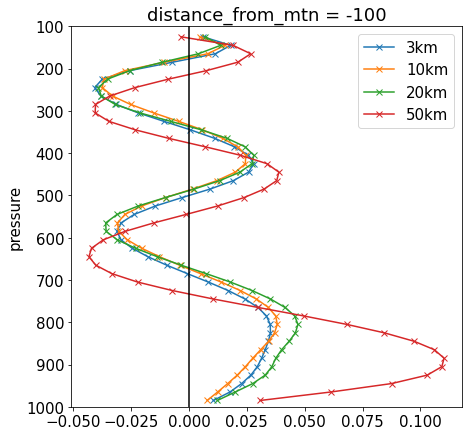

In [38]:
plt.figure(figsize=(7,7))
dx3 .wmean.sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',marker='x',label='3km')
dx10.wmean.sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',marker='x',label='10km')
dx20.wmean.sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',marker='x',label='20km')
dx50.wmean.sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',marker='x',label='50km')
plt.legend();plt.axvline(0.,color='k')
plt.ylim(1000,100)

## T,q

In [53]:
%%time
for sim in (dx3,dx10,dx20,dx50):
    theta_temp = (300+sim.data.T)[120:160].mean(['Time','south_north']).load()
    sim.thetamean = interp_eta_to_pressure(sim.data,change_coords_eta(sim.data,theta_temp,center=sim.center,dx=sim.dx),0,dsinput=sim.input)
    sim.tmean = sim.thetamean*(sim.thetamean.pressure/1e3)**0.286
    p1=5;p2=16
    sim.tmean_hat_prime = hatprime(sim.tmean,p1,p2)

    qv_temp = sim.data.QVAPOR[120:160].mean(['Time','south_north']).load()
    sim.qvmean = interp_eta_to_pressure(sim.data,change_coords_eta(sim.data,qv_temp,center=sim.center,dx=sim.dx),0,dsinput=sim.input)
    sim.qvmean_hat_prime = Lc/cp*hatprime(sim.qvmean,p1,p2) # convert to K
    

CPU times: user 2.18 s, sys: 304 ms, total: 2.49 s
Wall time: 17.4 s


Text(0.5, 0, '')

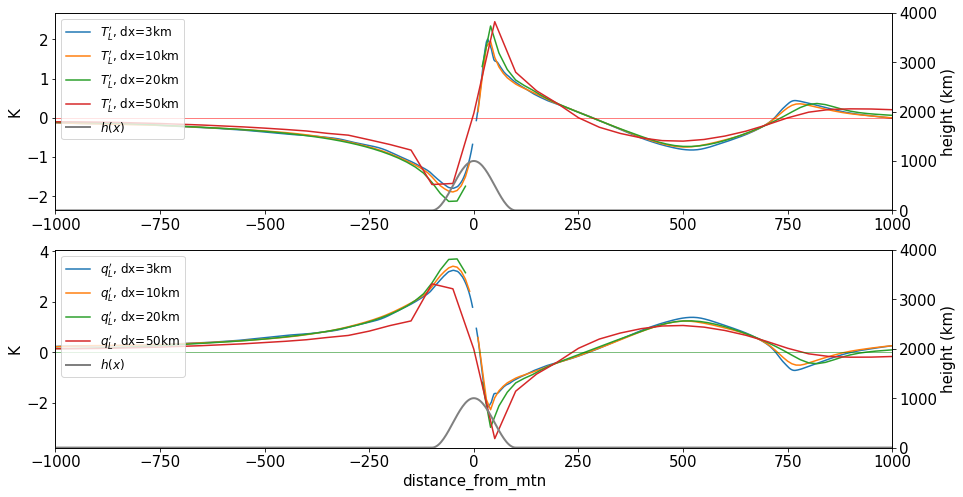

In [54]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()

# Panel a : temperature deviations
dx3 .tmean_hat_prime.plot(ax=ax,label=r"$T_L'$, dx=3km")
dx10.tmean_hat_prime.plot(ax=ax,label=r"$T_L'$, dx=10km")
dx20.tmean_hat_prime.plot(ax=ax,label=r"$T_L'$, dx=20km")
dx50.tmean_hat_prime.plot(ax=ax,label=r"$T_L'$, dx=50km")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

## Panel b : moisture deviations
dx3 .qvmean_hat_prime.plot(ax=ax2,label=r"$q_L'$, dx=3km")
dx10.qvmean_hat_prime.plot(ax=ax2,label=r"$q_L'$, dx=10km")
dx20.qvmean_hat_prime.plot(ax=ax2,label=r"$q_L'$, dx=20km")
dx50.qvmean_hat_prime.plot(ax=ax2,label=r"$q_L'$, dx=50km")
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-1000,1000)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    hrhgt.plot(ax=am,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4000)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=12,loc=2)

ax.set_xlabel('')

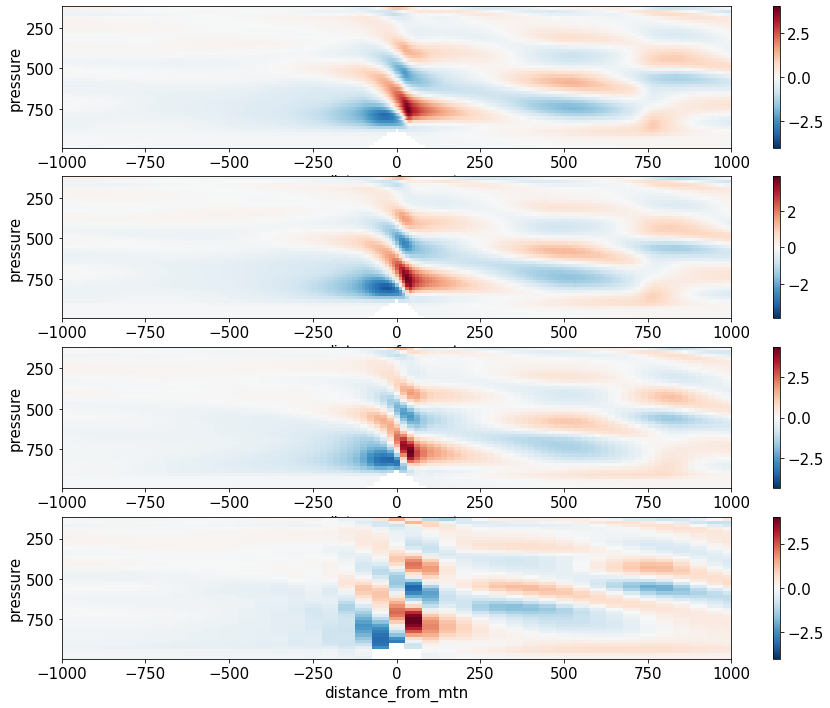

In [56]:
fig,axs = plt.subplots(4,1,figsize=(15,12))
for ax,sim in zip(axs,(dx3,dx10,dx20,dx50)):
    (sim.tmean-sim.tmean.sel(distance_from_mtn=slice(-2500,-3000)).mean('distance_from_mtn')).plot(ax=ax,y='pressure',yincrease=False)
    ax.set_xlim(-1000,1000)

# Moist runs

## Precip

In [15]:
for sim in (nocpdx20,zmfdx20,tiedtkedx20,nocpdx50):
    sim.finalday = len(sim.data.Time)//4
    if 'RAINC' in sim.data.variables:
        sim.rain = change_coords_sfc(((sim.data.RAINNC[-1]-sim.data.RAINNC[200]+sim.data.RAINC[-1]-sim.data.RAINC[200])/(len(sim.data.Time)-200)*4).mean('south_north'),center=sim.center,dx=sim.dx)
    else:
        sim.rain = change_coords_sfc(((sim.data.RAINNC[-1]-sim.data.RAINNC[200])/(len(sim.data.Time)-200)*4).mean('south_north'),center=sim.center,dx=sim.dx)

In [16]:
rain_3km_all = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.days0-250.nc')
rain_3km = change_coords_sfc(rain_3km_all[400:].mean(['Time','south_north']))

(-1000.0, 1000.0)

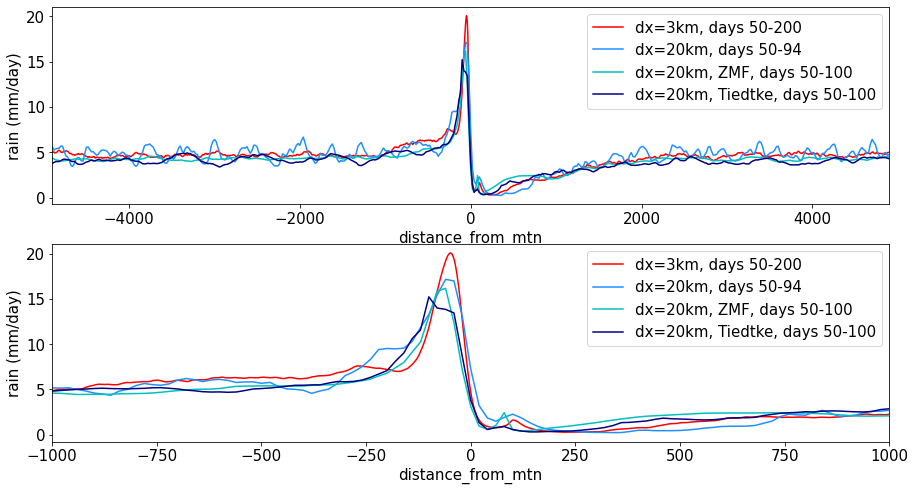

In [19]:
_,axs = plt.subplots(2,1,figsize=(15,8))
for ax in axs:
    rain_3km.plot(ax=ax,color='r',label='dx=3km, days 50-200')
    nocpdx20.rain.plot(ax=ax,color='dodgerblue',label='dx=20km, days 50-%i'%nocpdx20.finalday)
    zmfdx20.rain.plot(ax=ax,color='c',label='dx=20km, ZMF, days 50-100')
    tiedtkedx20.rain.plot(ax=ax,color='navy',label='dx=20km, Tiedtke, days 50-100')
    ax.set_ylabel('rain (mm/day)')
    ax.legend()
axs[0].set_xlim(-4900,4900)
axs[1].set_xlim(-1000,1000)

(-1000.0, 1000.0)

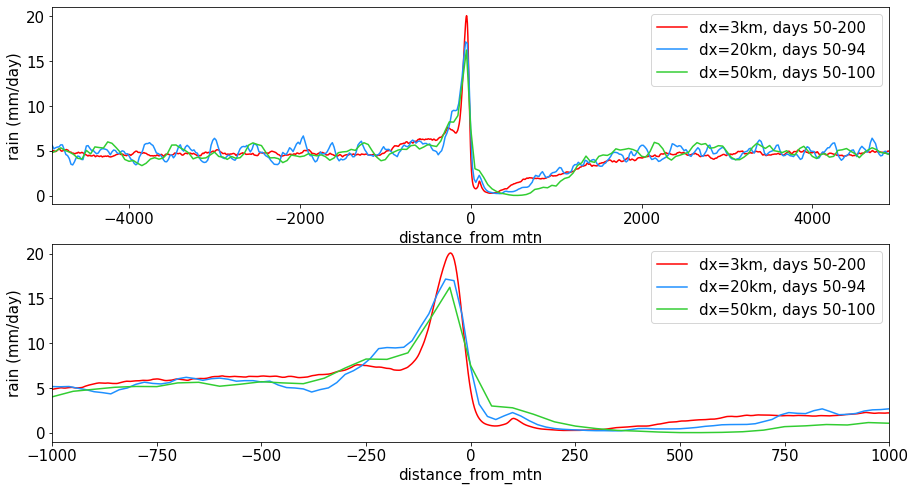

In [21]:
_,axs = plt.subplots(2,1,figsize=(15,8))
for ax in axs:
    rain_3km.plot(ax=ax,color='r',label='dx=3km, days 50-200')
    nocpdx20.rain.plot(ax=ax,color='dodgerblue',label='dx=20km, days 50-%i'%nocpdx20.finalday)
    nocpdx50.rain.plot(ax=ax,color='limegreen',label='dx=50km, days 50-%i'%nocpdx50.finalday)
    ax.set_ylabel('rain (mm/day)')
    ax.legend()
axs[0].set_xlim(-4900,4900)
axs[1].set_xlim(-1000,1000)

## W

In [22]:
%%time
for sim in (nocpdx20,zmfdx20,tiedtkedx20,nocpdx50):
    w_temp = sim.data.W[200:].mean(['Time','south_north']).load()
    sim.wmean = interp_eta_to_pressure(sim.data,change_coords_eta(sim.data,w_temp,staggered=True,center=sim.center,dx=sim.dx),1,dsinput=sim.input)

CPU times: user 896 ms, sys: 225 ms, total: 1.12 s
Wall time: 5.76 s


In [24]:
deepinput = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfinput_d01")
w_temp = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.W.days100-250.nc")
wmean3km = interp_eta_to_pressure(deepinput,change_coords_eta(deepinput,w_temp,staggered=True),1,dsinput=deepinput)

In [25]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n
wlevs=levs(0.4,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

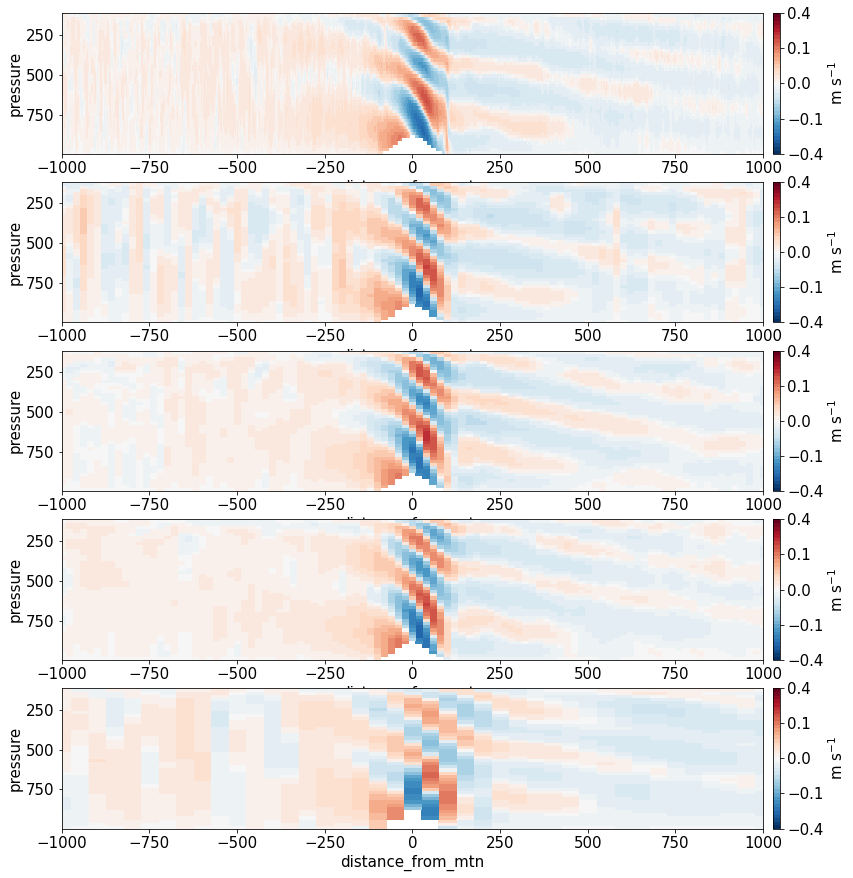

In [27]:
fig,axs = plt.subplots(5,1,figsize=(15,15))

wmean3km.plot(ax=axs[0],y='pressure',yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})
axs[0].set_xlim(-1000,1000)
for ax,sim in zip(axs[1:],(nocpdx20,zmfdx20,tiedtkedx20,nocpdx50)):
    sim.wmean.plot(ax=ax,y='pressure',yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})
    ax.set_xlim(-1000,1000)

(-100.0, 4000.0)

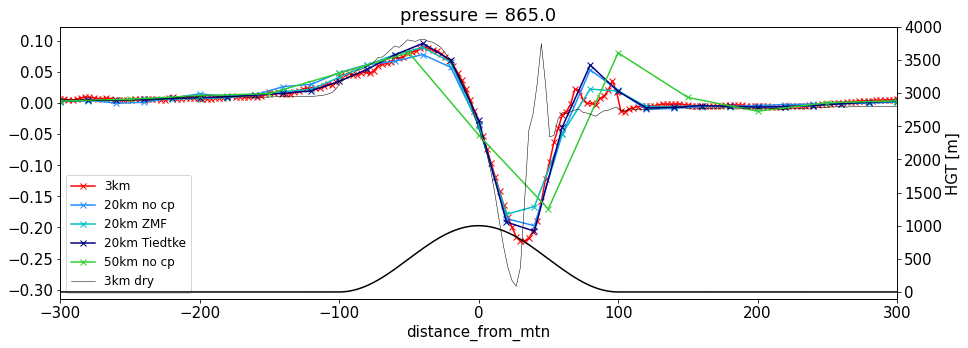

In [35]:
plt.figure(figsize=(15,5))
wmean3km         [6].plot(marker='x',color='r'         ,label='3km')
nocpdx20   .wmean[6].plot(marker='x',color='dodgerblue',label='20km no cp')
zmfdx20    .wmean[6].plot(marker='x',color='c'         ,label='20km ZMF')
tiedtkedx20.wmean[6].plot(marker='x',color='navy'      ,label='20km Tiedtke')
nocpdx50   .wmean[6].plot(marker='x',color='limegreen' ,label='50km no cp')
dx3   .wmean[6].plot(linewidth=0.5,color='k',label='3km dry')
plt.legend(fontsize=12)
plt.twinx()
hrhgt.plot(color='k')
plt.xlim(-300,300)
plt.ylim(-100,4000)


(1000.0, 100.0)

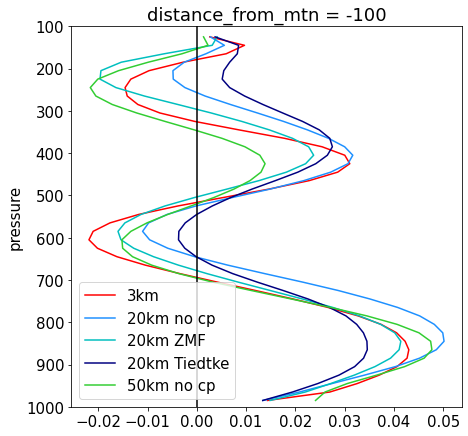

In [42]:
plt.figure(figsize=(7,7))
wmean3km         .sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',color='r'         ,label='3km')
nocpdx20   .wmean.sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',color='dodgerblue',label='20km no cp')
zmfdx20    .wmean.sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',color='c'         ,label='20km ZMF')
tiedtkedx20.wmean.sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',color='navy'      ,label='20km Tiedtke')
nocpdx50   .wmean.sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',color='limegreen' ,label='50km no cp')
#dx3        .wmean.sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',linewidth=0.5,color='k',label='3km dry')
plt.legend();plt.axvline(0.,color='k')
plt.ylim(1000,100)

## T,q

In [59]:
%%time
for sim in (nocpdx20,zmfdx20,tiedtkedx20,nocpdx50):
    theta_temp = (300+sim.data.T)[200:].mean(['Time','south_north']).load()
    sim.thetamean = interp_eta_to_pressure(sim.data,change_coords_eta(sim.data,theta_temp,center=sim.center,dx=sim.dx),0,dsinput=sim.input)
    sim.tmean = sim.thetamean*(sim.thetamean.pressure/1e3)**0.286
    p1=6;p2=16
    sim.tmean_hat_prime = hatprime(sim.tmean,p1,p2)

    qv_temp = sim.data.QVAPOR[200:].mean(['Time','south_north']).load()
    sim.qvmean = interp_eta_to_pressure(sim.data,change_coords_eta(sim.data,qv_temp,center=sim.center,dx=sim.dx),0,dsinput=sim.input)
    sim.qvmean_hat_prime = Lc/cp*hatprime(sim.qvmean,p1,p2) # convert to K
    

CPU times: user 1.05 s, sys: 118 ms, total: 1.17 s
Wall time: 2.98 s


In [60]:
theta3km = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.THETA.days100-250.nc")
theta3km = interp_eta_to_pressure(deepinput,change_coords_eta(deepinput,theta3km),0,dsinput=deepinput)
tmean3km = theta3km*(theta3km.pressure/1e3)**0.286
tmean3km_hat_prime = hatprime(tmean3km,p1,p2)

qvmean3km = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.QVAPOR.days100-250.nc")
qvmean3km = interp_eta_to_pressure(deepinput,change_coords_eta(deepinput,qvmean3km),0,dsinput=deepinput)
qvmean3km_hat_prime = Lc/cp*hatprime(qvmean3km,p1,p2)

Text(0.5, 1.0, "$q_L'$")

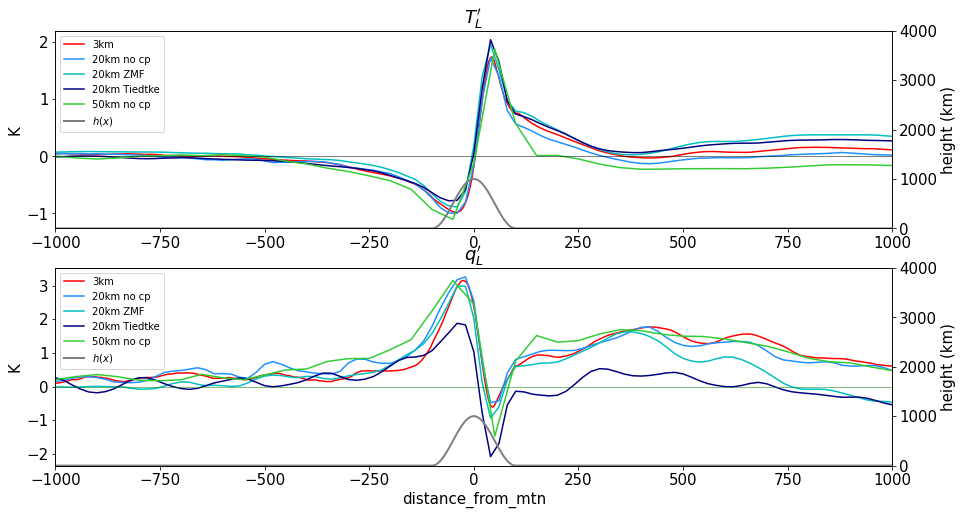

In [61]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()

# Panel a : temperature deviations
tmean3km_hat_prime         .plot(ax=ax,color='r'         ,label='3km')
nocpdx20   .tmean_hat_prime.plot(ax=ax,color='dodgerblue',label='20km no cp')
zmfdx20    .tmean_hat_prime.plot(ax=ax,color='c'         ,label='20km ZMF')
tiedtkedx20.tmean_hat_prime.plot(ax=ax,color='navy'      ,label='20km Tiedtke')
nocpdx50   .tmean_hat_prime.plot(ax=ax,color='limegreen' ,label='50km no cp')

ax.axhline(0.,linestyle='-',linewidth='0.5',color='k')


## Panel b : moisture deviations
qvmean3km_hat_prime         .plot(ax=ax2,color='r'         ,label='3km')
nocpdx20   .qvmean_hat_prime.plot(ax=ax2,color='dodgerblue',label='20km no cp')
zmfdx20    .qvmean_hat_prime.plot(ax=ax2,color='c'         ,label='20km ZMF')
tiedtkedx20.qvmean_hat_prime.plot(ax=ax2,color='navy'      ,label='20km Tiedtke')
nocpdx50   .qvmean_hat_prime.plot(ax=ax2,color='limegreen' ,label='50km no cp')
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-1000,1000)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    hrhgt.plot(ax=am,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4000)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=10,loc=2)

ax.set_xlabel('')
ax.set_title(r"$T_L'$")
ax2.set_title(r"$q_L'$")